In [477]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from lib.Utility import exportExcelWithTimeStamp, calculateSize2, calculate_gain_full, calculateSize1, calculate_gain_quotaMin, calculate_gainHAD

from datetime import date, timedelta
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
import joblib
import plotly.express as px
from plotly import graph_objects as go
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# features = ['B365H','B365D', 'B365A',	'B365<2.5']
features = [
    # 'HomeGoalsCumulative', 'AwayGoalsCumulative'
    # , 'HomePointsCumulative','AwayPointsCumulative',
    #  'HomeGoalsConcededCumulative',	'AwayGoalsConcededCumulative',
            #  'PointsDifference',
            #  'ConcededGoalsDifference'
            #  'GoalsDifference',
            #  'AwayGoalsRatio'
            #  'HomeGoalsRatio'
                        # ,'AwayGoalGap'
            # , 'HomeGoalGap',
            #  'AwayPointGap'
            # , 'HomePointGap'
            #  , 'B365D',
               'B365H',
               'EloRatio'
              # ,  'FormRatio'
              # , 'RecentFormRatio'
            # , 'B365A'
            # , 'B365>2.5'
            ]
# features = ['HomeGoalsCumulative', 'AwayGoalsCumulative', 'AwayPointsCumulative', 'HomeGoalsConcededCumulative']
# features = ['HomeGoalsCumulative', 'AwayGoalsConcededCumulative']
# features = ['HomeGoalsCumulative', 'HomePointsCumulative']
# features = ['PointsDifference', 'HomeGoalsRatio', 'AwayPointGap', 'HomePointGap']
threshold = 0.5

In [478]:
data = pd.read_excel('data/mergedDataFull2.xlsx')
# data = pd.read_excel('data/engdata/24-25.xlsx')
# data = pd.read_excel('data/mergedDataSerieB.xlsx')
data['Cluster'] = np.where(data['FTR'] == 'H', 1, np.where(data['FTR'] == 'A', 2, 0))
# data['Cluster'] = np.where(data['FTHG'] == data['FTAG'], 1, 0) #data['FTR'].map({'D': 0, 'H': 1, 'A': 2}) 
# data = data[data['HomeGoalsCumulative'].notna()]
# data = data[data['AwayGoalsCumulative'].notna()]
# data = data[data['HomePointsCumulative'].notna()]
# data = data[data['AwayPointsCumulative'].notna()]
# data = data[data['HomeGoalsConcededCumulative'].notna()]
# data = data[data['AwayGoalsConcededCumulative'].notna()]
data = data[data['B365D'].notna()]
data = data[data['B365H'].notna()]
data = data[data['B365A'].notna()]
data['FormRatio'] = data['HomeForm']/data['AwayForm']
data['RecentFormRatio'] = data['HomeRecentHomeForm']/data['AwayRecentAwayForm']

data.replace([np.inf, -np.inf], 100, inplace=True)
data = data[data['RecentFormRatio'].notna()]
data = data[data['FormRatio'].notna()]
# data = data[data['B365H']>1.6]
# data.dropna()
data.tail(10)

,Date,Div,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,"MaxC<2,5","AvgC>2,5","AvgC<2,5",HomePointGap,AwayPointGap,HomeGoalGap,AwayGoalGap,Cluster,FormRatio,RecentFormRatio
8298,2024-05-10,I2,19:30:00,Ascoli,Pisa,2,1,H,1.0,0.0,...,1.75,2.20,1.65,-8,8,-14,14,1,1.166667,1.166667
8299,2024-05-10,I2,19:30:00,Bari,Brescia,2,0,H,1.0,0.0,...,2.11,1.80,1.99,-13,13,-8,8,1,3.250000,3.250000
8300,2024-05-10,I2,19:30:00,Catanzaro,Sampdoria,1,3,A,1.0,1.0,...,2.19,1.76,2.04,6,-6,8,-8,2,1.000000,1.000000
8301,2024-05-10,I2,19:30:00,Como,Cosenza,1,1,D,0.0,1.0,...,2.88,1.42,2.76,26,-26,11,-11,0,1.500000,1.500000
8302,2024-05-10,I2,19:30:00,Cremonese,Cittadella,3,0,H,2.0,0.0,...,2.57,1.51,2.49,18,-18,7,-7,1,0.833333,0.833333
8303,2024-05-10,I2,19:30:00,FeralpiSalo,Ternana,0,1,A,0.0,1.0,...,2.88,1.42,2.78,-7,7,2,-2,2,2.750000,2.750000
8304,2024-05-10,I2,19:30:00,Lecco,Modena,2,3,A,1.0,3.0,...,2.09,1.81,1.97,-18,18,-5,5,2,0.230769,0.230769
8305,2024-05-10,I2,19:30:00,Reggiana,Parma,1,1,D,1.0,0.0,...,2.51,1.54,2.41,-29,29,-28,28,0,0.750000,0.750000
8306,2024-05-10,I2,19:30:00,Spezia,Venezia,2,1,H,0.0,1.0,...,2.12,1.77,2.02,-29,29,-34,34,1,1.000000,1.000000
8307,2024-05-10,I2,19:30:00,Sudtirol,Palermo,0,1,A,0.0,0.0,...,1.95,1.93,1.85,-6,6,-15,15,2,1.333333,1.333333


In [479]:
x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 42,shuffle=True)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()

print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')


X_train: (4550, 2) 
X_test: (1951, 2) 
y_train: (4550,) 
y_test: (1951,)


In [480]:

# Set regularization rate
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
reg = 0.01

# train a logistic regression model on the training set
model1 = LogisticRegression(C=1/reg, multi_class='ovr',
                            solver="liblinear", random_state=42).fit(x_train, y_train)

# from sklearn.ensemble import RandomForestClassifier
# model2 = RandomForestClassifier( random_state=42
#                                 , min_samples_split=100
#                                 , max_depth=4
#                                 , n_estimators=100
#                                 # , max_features = 'log2'
#                                 # ,criterion = 'entropy'
#                                 # , class_weight = 'balanced'
#                                   ).fit(x_train, y_train)
# model2 = DecisionTreeClassifier(random_state=42
#                                 , min_samples_split=100
#                                 # , class_weight={1: 1, 0: 1, 2: 1}
#                                 # , class_weight='balanced'
#                                 , max_depth=2  # , ccp_alpha= 0.00001
#                                 # , max_features= 3
#                                 ).fit(x_train, y_train)
plt.figure(figsize=(30, 20))

class_mapping = {
    0: "Draw",
    1: "Home",
    2: "Away"
}

# print(model2.classes_)
# tree.plot_tree(model2, feature_names=features, filled=True, fontsize=15               # ,proportion=True  # Mostra la proporzione delle classi
#                , class_names=pd.Series(model2.classes_).map(class_mapping) #['Away', 'Home',  'Draw']
#                )
# plt.show()
# joblib.dump(model, "./Soccer-ml1.joblib")

# model = joblib.load("Soccer-ml3.joblib")

<Figure size 3000x2000 with 0 Axes>

In [481]:
from xgboost import XGBClassifier

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

model2 = XGBClassifier(
    random_state=42,
    min_child_weight=100,  # XGBoost non ha direttamente `min_samples_split`, ma puoi usare `min_child_weight`
    max_depth=3,

    # n_estimators=100,
    # gamma=3,  # Puoi usare gamma per aggiungere regolarizzazione
    # class_weight='balanced'  # XGBoost gestisce classi sbilanciate in modo diverso
).fit(x_train, y_train)

In [482]:
# from sklearn.tree import export_graphviz
# import graphviz

# # Supponiamo che il modello sia già addestrato
# # Supponiamo di avere feature_names e class_names definite

# dot_data = export_graphviz(model, out_file=None, feature_names=features, proportion=True  # Mostra la proporzione delle classi
#                            , class_names=['Home/Away', 'Draw'], filled=True,
#                            rounded=True,
#                            special_characters=True)

# # Creare un oggetto graphviz Source
# graph = graphviz.Source(dot_data)

# # Visualizzare il grafico
# # graph.view()

# # Per salvare il grafico in un file PDF, PNG, ecc.
# # Questo salverà il grafico come "decision_tree.pdf"
# graph.render("decision_tree")

In [483]:
def custom_predict(X, threshold, model):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)
# Definisci una funzione che applica la logica descritta
def calculate_gain(row, quota_minima):
    
    if(row['predictions'] > threshold):
        if row['Cluster'] == row['predictions']:
            if row['predictions'] == 1 and row['B365H'] > quota_minima:
                return row['B365H']-1
            elif row['predictions'] == 2 and row['B365A'] > quota_minima:
                return row['B365A']-1
            elif row['predictions'] == 0 and row['B365D'] > quota_minima:
                return row['B365D']-1
        else:
            if((row['predictions'] == 0 and row['B365D'] > quota_minima) or (row['predictions'] == 2 and row['B365A'] > quota_minima) or (row['predictions'] == 1 and row['B365H'] > quota_minima)):
                return -1


def calculate_gainHAD2(row, model):
            quotaMin = 1.5
    # if row['pred_prob'+model] > threshold:
    # if row['predictions'+model] != 1:
        # if row['Cluster'] == row['predictions'+model]:
            if row['predictions'+model] == 0:
                if(row['B365D'] >= quotaMin):
                    if (row['FTR'] == 'D'):
                            return row['B365D']-1
                    else:
                        return -1
            elif row['predictions'+model] == 1:
                if(row['B365H'] >= quotaMin):
                    if (row['FTR'] == 'H'):
                        return row['B365H']-1
                    else:
                        return -1
            elif row['predictions'+model] == 2:
                if(row['B365A'] >= quotaMin):
                    if (row['FTR'] == 'A'):
                        return row['B365A']-1
                    else:
                        return -1       


In [484]:
# x_test = data[features]
# y_test = data['Cluster']

df = x_test.copy()
df['predictionsLog'] = custom_predict(x_test.sort_index(), threshold, model1)
df['predictionsDT'] = model2.predict(x_test.sort_index())
# df['predictionsDT'] = custom_predict(x_test.sort_index(), threshold, model2)
pred_prob1 = model1.predict_proba(x_test.sort_index())
pred_prob2 = model2.predict_proba(x_test.sort_index())

df2 = pd.DataFrame(pred_prob1)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)



finalDataset = data[data.index.isin(x_test.index)]
finalDataset = finalDataset.copy()
finalDataset['predictionsLog'] = df['predictionsLog']
finalDataset['pred_probLog'] = df[1]

df2 = pd.DataFrame(pred_prob2)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)

finalDataset['predictionsDT'] = df['predictionsDT']
finalDataset['pred_probDT0'] = df['0_y']
finalDataset['pred_probDT1'] = df['1_y']
finalDataset['pred_probDT2'] = df['2_y']

finalDataset['size1'] = calculateSize1(finalDataset['B365H'], finalDataset['B365A'])
finalDataset['size2'] = calculateSize2(finalDataset['B365H'], finalDataset['B365A'])
finalDataset['gainLog1'] = np.where((finalDataset['FTR'] == 'D') & (finalDataset['pred_probLog'] > threshold),
                                finalDataset['B365D']-1, np.where((finalDataset['FTR'] != 'D') & (finalDataset['pred_probLog'] > threshold), -1, None))
finalDataset['gainLog2'] = finalDataset.apply(calculate_gain_full, axis=1, args=('Log',))
# finalDataset['gainDT1'] = np.where((finalDataset['FTR'] == 'D') & (finalDataset['pred_probDT'] > threshold),
#                                 finalDataset['B365D']-1, np.where((finalDataset['FTR'] != 'D') & (finalDataset['pred_probDT'] > threshold), -1, None))
finalDataset['gainDT2'] = finalDataset.apply(calculate_gainHAD2, axis=1, args=('DT',))


equityDT2 = finalDataset['gainDT2'].sum()
print("EquityDT2", equityDT2)

print(f"AccuracyDT score: {round(100*accuracy_score(y_test, df['predictionsDT']),2)}%")
exportExcelWithTimeStamp(finalDataset, "Dataframe/", "df.xlsx")

EquityDT2 -92.85
AccuracyDT score: 49.05%


In [485]:
from sklearn.metrics import classification_report
# Ottieni il rapporto di classificazione
report = classification_report(y_test, df['predictionsDT'], output_dict=True)
print(report)
# Stampa l'accuratezza per ciascuna classe
for class_name, metrics in report.items():
    if class_name.isdigit():  # Verifica che si tratti di una classe e non di un aggregato (es. accuracy globale)
        print(f"Classe {class_name}: Recall (Accuratezza della classe) = {metrics['recall']:.2f}")

{'0': {'precision': 0.3132530120481928, 'recall': 0.05108055009823183, 'f1-score': 0.08783783783783784, 'support': 509.0}, '1': {'precision': 0.505718954248366, 'recall': 0.7641975308641975, 'f1-score': 0.6086529006882988, 'support': 810.0}, '2': {'precision': 0.484472049689441, 'recall': 0.4936708860759494, 'f1-score': 0.48902821316614425, 'support': 632.0}, 'accuracy': 0.49051768323936445, 'macro avg': {'precision': 0.43448133866199995, 'recall': 0.4363163223461262, 'f1-score': 0.39517298389742694, 'support': 1951.0}, 'weighted avg': {'precision': 0.4486235117772595, 'recall': 0.49051768323936445, 'f1-score': 0.43402569950691167, 'support': 1951.0}}
Classe 0: Recall (Accuratezza della classe) = 0.05
Classe 1: Recall (Accuratezza della classe) = 0.76
Classe 2: Recall (Accuratezza della classe) = 0.49


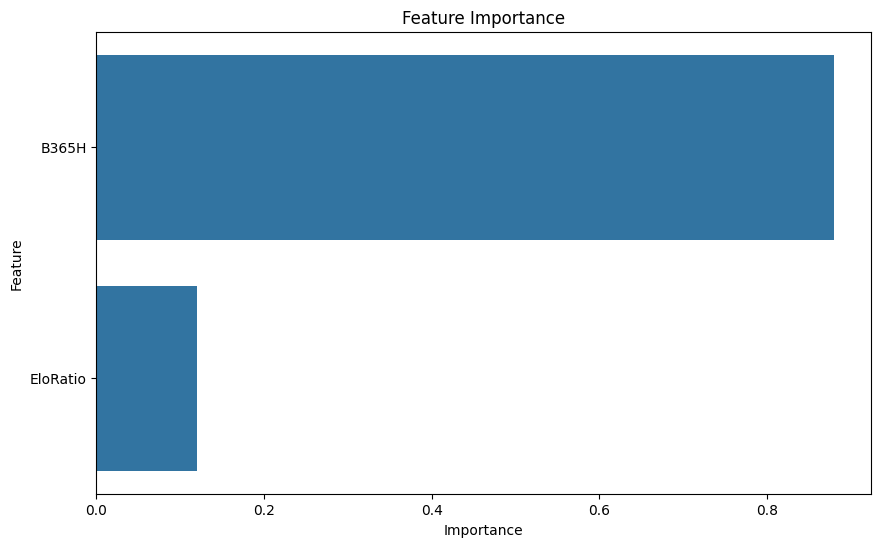

In [486]:
import seaborn as sns
# Ottenere le importanze delle caratteristiche
importances = model2.feature_importances_

# Creare un DataFrame per visualizzare le importanze
import pandas as pd
feature_names = x_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizzare le importanze delle caratteristiche
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [487]:
importances = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_], axis=0)


forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

In [ ]:
# joblib.dump(model, "./Soccer-ml7L1.joblib")